# 지도학습-SGDRegressor

In [1]:
from hossam import *

from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

# 성능 평가 지표 모듈
from sklearn.metrics import(
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

# 확률적 경사 하강법
from sklearn.linear_model import SGDRegressor

c:\Users\wodyd\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📦 아이티윌 이광호 강사가 제작한 라이브러리를 사용중입니다.
📚 자세한 사용 방법은 https://py.hossam.kr 을 참고하세요.
📧 Email: leekh4232@gmail.com
🎬 Youtube: https://www.youtube.com/@hossam-codingclub
📝 Blog: https://blog.hossam.kr/
🔖 Version: 0.4.18

✅ 시각화를 위한 한글 글꼴(NotoSansKR-Regular)이 자동 적용되었습니다.


In [2]:
origin = load_data('fish_processed')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

농어의 길이,높이,두께,무게를 조사한 데이터의 전처리 버전
데이터셋 크기: (56, 4)
열 개수: 4
행 개수: 56
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB
None


,길이,높이,두께,무게
0,8.4,2.11,1.41,1.931521
1,13.7,3.53,2.00,3.496508
2,15.0,3.82,2.43,3.713572
3,16.2,4.59,2.63,3.960813
4,17.4,4.59,2.94,4.262680


## 1. 훈련, 검증 데이터 분리

In [3]:
df = origin

yname = '무게'
x = df.drop(columns = [yname])
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.25, random_state = 52
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((42, 3), (14, 3), (42,), (14,))

## 2. 모델 적합

In [6]:
%%time

# SGDRegressor를 위한 경고 무시 설정
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category = ConvergenceWarning)

# SGDRegressor 모델 정의(n_jobs 없음)
pipe = Pipeline(
    [('scaler', StandardScaler()), ('model', SGDRegressor(random_state = 52))]
)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    # 규제 종류
    'model__penalty': ['l2', 'l1', 'elasticnet'],
    # 규제 강도 (로그 스케일) -> SGD 규제 강도 표준 범위
    'model__alpha': [0.001, 0.01,0.1],
    # elasticent일 때만 의미 있음
    'model__l1_ratio': [0.15, 0.5, 0.85],
    # 학습률 전략
    'model__learning_rate': ['optimal', 'invscaling']
}

# 그리드 서치 객체 생성
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5, scoring = 'r2', n_jobs = -1)

gs.fit(x_train, y_train)

estimator = gs.best_estimator_
estimator

CPU times: total: 156 ms
Wall time: 199 ms


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"loss loss: str, default='squared_error'The loss function to be used. The possible values are 'squared_error','huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'The 'squared_error' refers to the ordinary least squares fit.'huber' modifies 'squared_error' to focus less on getting outlierscorrect by switching from squared to linear loss past a distance ofepsilon. 'epsilon_insensitive' ignores errors less than epsilon and islinear past that; this is the loss function used in SVR.'squared_epsilon_insensitive' is the same but becomes squared loss pasta tolerance of epsilon.More details about the losses formulas can be found in the:ref:`User Guide `.",'squared_error'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'elasticnet'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.1
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 cor

## 3. 성능 평가
### 1. 성능 평가 지표

In [8]:
y_pred = estimator.predict(x_test)

result_df = DataFrame(
    {
        '결정계수(R2)': r2_score(y_test, y_pred),
        '평균절대오차(MAE)': mean_absolute_error(y_test, y_pred),
        '평균제곱오차(MSE)': mean_squared_error(y_test, y_pred),
        '평균오차(RMSE)': np.sqrt(mean_squared_error(y_test, y_pred)),
        '평균 절대 백분오차 비율(MAPE)': mean_absolute_percentage_error(y_test, y_pred),
        '평균 비율 오차(MPE)': np.mean((y_test - y_pred) / y_test * 100)
    },
    index = ['성능지표']
)

display(result_df)

,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE)
성능지표,0.980505,0.126108,0.022628,0.150427,0.023395,1.519789


### 2. 과적합 여부 확인

In [15]:
train_sizes, train_scores, cv_scores = learning_curve(
    estimator = estimator,
    X = x,
    y = y,
    cv = 5,
    scoring = 'neg_root_mean_squared_error',
    train_sizes = np.linspace(0.1, 1.0, 8),
    shuffle = True,
    random_state = 52,
    n_jobs = -1
)

# neg RMSE -> RMSE
train_rmse = -train_scores
cv_rmse = -cv_scores

# 평균/표준편차
train_mean = train_rmse.mean(axis = 1)
cv_mean = cv_rmse.mean(axis = 1)
cv_std = cv_rmse.std(axis = 1)

# 마지막 지점 기준 정량 판정
final_train = train_mean[-1]
final_cv = cv_mean[-1]
final_std = cv_std[-1]

gap_ratio = final_train / final_cv
var_ratio = final_std / final_cv


# 과소적합 기준선 (some_threshold)
# 기준모형 RMSE (평균 예측)

y_mean = y.mean()
rmse_naive = np.sqrt(np.mean((y-y_mean) ** 2))

# 분산 기반
std_y = y.std()

# 최소 설명령(R2) 기반
min_r2 = 0.10
rmse_r2 = np.sqrt((1 - min_r2) * np.var(y))

# 최종 threshold (가장 관대한 기준)
# -> 원래 some_threshold는 도메인 지식 수준에서 이 모델은 최소 어느 정도의 성능은 내야 한다는 기준을 설정하는 것
some_threshold = min(rmse_naive, std_y, rmse_r2)

if gap_ratio >= 0.95 and final_cv > some_threshold:
    status = ('과소적합: bias 큼')
elif gap_ratio <= 0.8:
    status = ('과대적합: variance 큼')
elif gap_ratio <= 0.95 and var_ratio <= 0.10:
    status = ('일반화 양호')
elif var_ratio > 0.15:
    status = ('데이터 부족: 분산 큼')
else:
    status = ('판단 유보: 추가 지표 필요')

# 정량 결과 표
result_df = DataFrame({
    '지표': [
        'Train RMSE',
        'CV RMSE 평균',
        'CV RMSE 표준편차',
        'Train/CV 비율',
        'CV 변동성 비율',
        '판정 결과'
    ],
    '값':[
        final_train,
        final_cv,
        final_std,
        gap_ratio,
        var_ratio,
        status,
    ]
})

result_df

,지표,값
0,Train RMSE,0.241133
1,CV RMSE 평균,0.321364
2,CV RMSE 표준편차,0.182496
3,Train/CV 비율,0.750342
4,CV 변동성 비율,0.56788
5,판정 결과,과대적합: variance 큼


### 3. 학습곡선

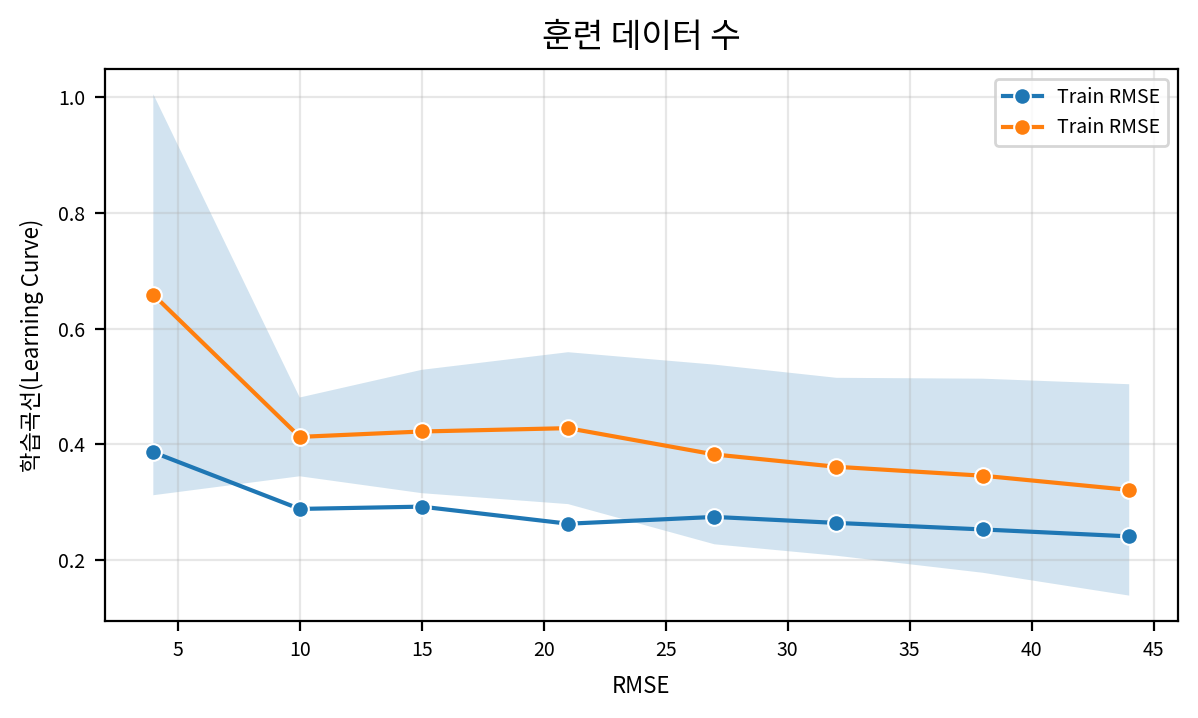

In [13]:
# 시각화

figsize = (1200/my_dpi, 720/my_dpi)
fig, ax = plt.subplots(1, 1, figsize = figsize, dpi = my_dpi)

sb.lineplot(x = train_sizes, y = train_mean, marker = 'o', markeredgecolor = '#ffffff', label ='Train RMSE')
sb.lineplot(x = train_sizes, y = cv_mean, marker = 'o', markeredgecolor = '#ffffff', label ='Train RMSE')

plt.fill_between(
    train_sizes, cv_mean - cv_std, cv_mean + cv_std, alpha = 0.2, label = 'CV +- 1 std'
)
ax.set_title('훈련 데이터 수', fontsize=12, pad= 8)
ax.set_xlabel('RMSE', fontsize=8, labelpad=5)
ax.set_ylabel('학습곡선(Learning Curve)', fontsize=8, labelpad=5)
ax.grid(True, alpha = 0.3)

plt.tight_layout()
plt.show()
plt.close()